In [1]:
import crispr_assembler as ca
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

%load_ext autoreload
%autoreload 2

import pickle

In [75]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
def process_path(path, cut = -1, save = 1):
    pairs_path = path + "/out/pairs/"
    files = sorted(os.listdir(pairs_path))
    
    print(pairs_path + files[0])
    
    read = ca.Read(pairs_path + files[0])
    read.correct_errors(minimum_occurences=5)
    gr = read.graph_from_pairs()[0]
    
    print('calc embs')
    ec = ca.EmbeddingsCalculator()
    ec.make_argsorts(gr[:cut, :cut])
    embs = ec.fit_predict(gr[:cut, :cut], njobs=32)
    
    if save:
        pickle.dump(read, open(path + "/read", 'wb'))
        np.save(path + "/graph", gr)
        np.save(path + "/embs", embs)
        
    return read, gr, embs

In [12]:
def load(path):
    return pickle.load(open(path + "/read", 'rb')), np.load(path + "/graph.npy"), np.load(path + "/embs.npy")

In [4]:
def unwrap_idx_to_spacer(idx_to_spacer):
    values_as_list = []
    for i in range(len(idx_to_spacer)):
        values_as_list.append(idx_to_spacer[i])
    return values_as_list

In [5]:
def continue_steps(reads, pointers):
    return any([pointers[i] < len(reads[i]) for i in range(len(reads))])

In [6]:
def merge_reads(reads, t=1, v = 1):
    spacers_lists = [unwrap_idx_to_spacer(x) for x in reads]#[unwrap_idx_to_spacer(x.index_to_cluster) for x in reads]
    pointers = [0 for i in range(len(reads))]
    merged_sp_to_idxes = {}
    old_idx_to_new_idx = [{} for i in range(len(reads))]
    
    curr = 0
    while continue_steps(spacers_lists, pointers):
        for i in range(len(reads)):
            if pointers[i] < len(reads[i]):
                spacer = spacers_lists[i][pointers[i]]
                
                dist, closest = ca.find_closest(merged_sp_to_idxes, spacer)
                if dist > t:
                    merged_sp_to_idxes[spacer] = curr
                    #new_sp_to_ids[i][spacer] = curr
                    old_idx_to_new_idx[i][pointers[i]] = curr
                    curr += 1
                else:
                    old_idx_to_new_idx[i][pointers[i]] = merged_sp_to_idxes[closest]
                
                pointers[i] += 1
                
                if curr % 100 == 0:
                    print(curr)
                

                if v:
                    print(i, pointers[i], spacer, dist, merged_sp_to_idxes)#, new_sp_to_ids[1])
                    
    return merged_sp_to_idxes,  old_idx_to_new_idx

In [7]:
def rearange(gr, order):
    new_gr = np.zeros((max(order.values()) + 1, max(order.values()) + 1))

    for i in tqdm.tqdm(range(len(order.keys()))):
        for j in range(len(order.keys())):
            new_gr[order[i], order[j]] = gr[i, j]

    return new_gr

In [105]:
path_slv = '/home/rykachevskiy/CRISPR_research/data/environmental/slv2/'
path_slo = '/home/rykachevskiy/CRISPR_research/data/environmental/os1/'

In [106]:
read_o, gr_o, embs_o = load(path_slo)
read_v, gr_v, embs_v = load(path_slv)

In [107]:
gb = pickle.load(open("./gb_rep_to_rep", 'rb'))

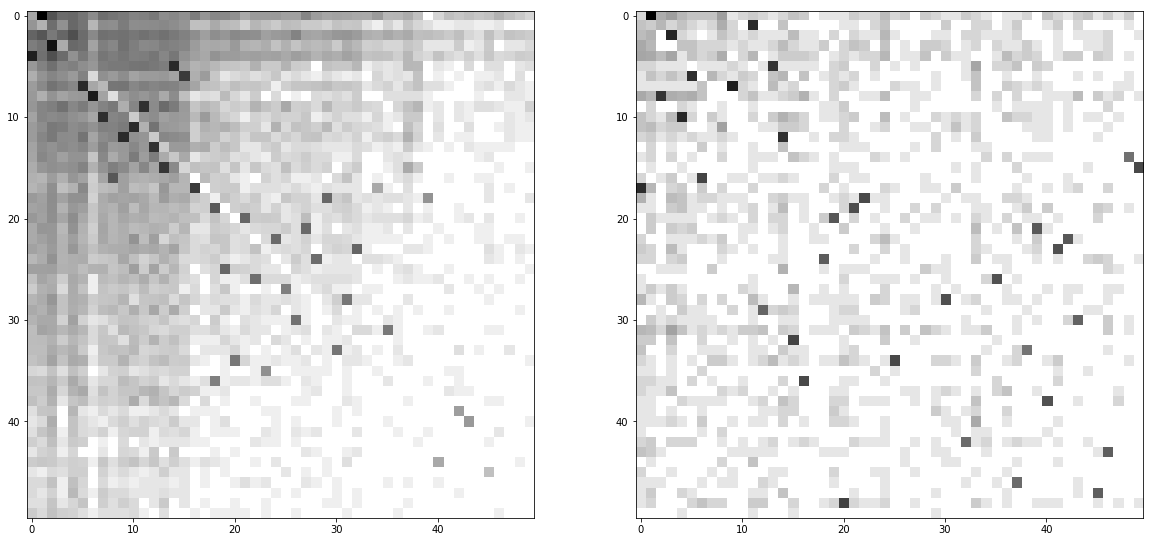

In [108]:
cut = 50
ca.plot_grs(gr_o[:cut, :cut], gr_v[:cut, :cut], log =1, s = 20)

In [109]:
#pred_o = gb.predict(embs_o).reshape(gr_o.shape[0] - 1, gr_o.shape[1] - 1)

arrays_o = ca.restore_arrays_greedy(gr_o, 2)[0]
pred_o = ca.graph_from_arrays(arrays_o)[0]

pred_v = gb.predict(embs_v).reshape(gr_v.shape[0] - 1, gr_v.shape[1] - 1)
arrays_v = ca.restore_arrays_all(pred_v)

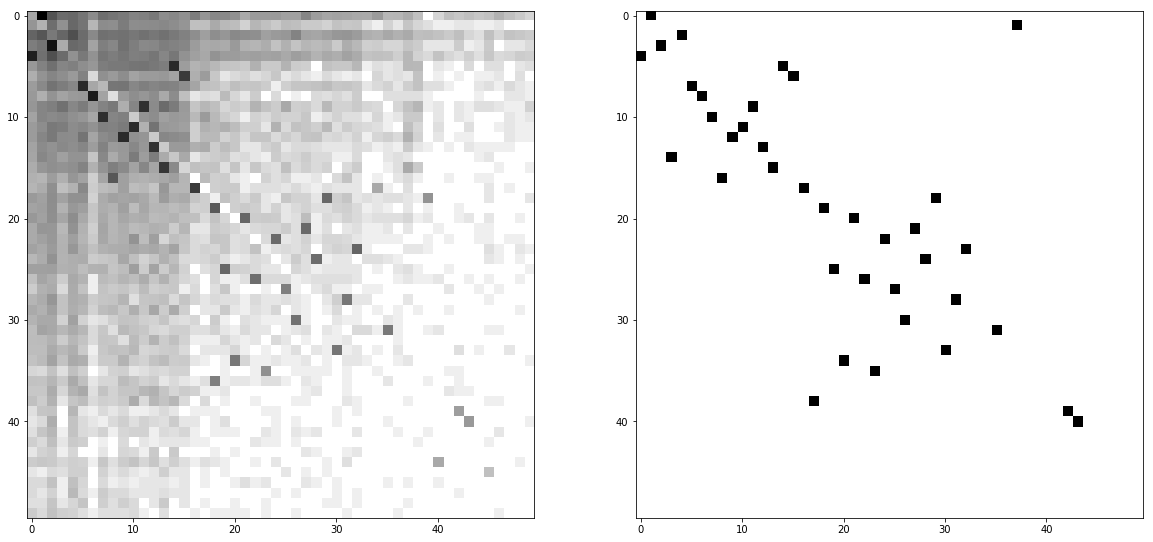

In [110]:
cut = 50
ca.plot_grs(gr_o[:cut, :cut], pred_o[:cut, :cut], log =1, s = 20)

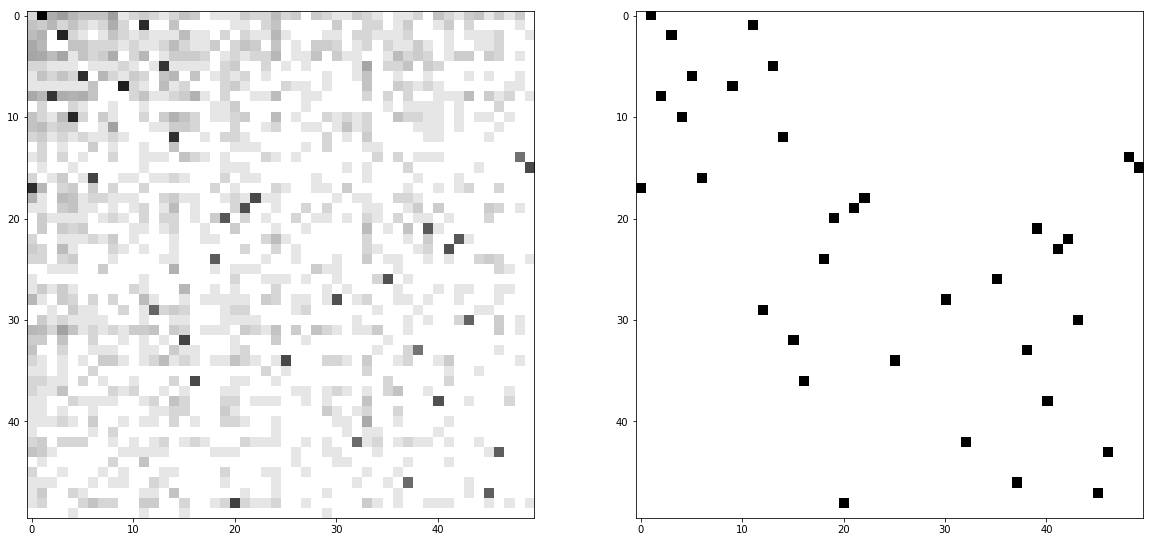

In [111]:
cut = 50
ca.plot_grs(gr_v[:cut, :cut], pred_v[:cut, :cut], log =1, s = 20)

In [112]:
arrays_v_f = np.array([x for x in arrays_v if len(x) > 2])
arrays_o_f = np.array([x for x in arrays_o if len(x) > 2])

In [113]:
mask_v = np.array([np.median(x) > 10 for x in ca.get_weights(gr_v, arrays_v_f)])
mask_o = np.array([np.median(x) > 10 for x in ca.get_weights(gr_o, arrays_o_f)])

In [114]:
arrays_v_f = arrays_v_f[mask_v]
arrays_o_f = arrays_o_f[mask_o]

In [115]:
len(arrays_v_f)

17

In [116]:
len(arrays_o_f)

28

In [117]:
arrrays_ov_f = ca.multiple_arrays_to_ids(
    dict(zip(np.arange(len(arrays_o_f)), [[read_o.index_to_cluster[x] for x in y] for y in arrays_o_f])),
    read_v.cluster_to_index)[0]

100%|██████████| 28/28 [00:00<00:00, 213.31it/s]


In [118]:
for idx in range(len(arrays_ov_f)):
    print("O in V", idx)
    for x in ca.print_alignments(ca.water_alignments(arrays_ov_f[idx], arrays_v_f),arrays_ov_f[idx]):
        print(x)
    print('____________________________')

O in V 0
 153 162 141 10  4   141 8   2   3   235
 -   -   -   -   -   -   8   2   3   -  
____________________________
O in V 1
 -   88  61  31  112 24  18  22  42  32  15  49  72  68  77  54  47  45  62  84  83  87  7   9   51  29  12  14  48  20  19  21  39  59 
 -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   7   9   51  29  12  14  48  20  19  21  39  59 
 -   -   -   -   -   24  18  22  42  32  15  49  72  68  77  54  47  45  62  84  -   -   -   -   -   -   -   -   -   -   -   -   -   -  
 83  88  61  31  -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -  
 -   -   -   -   -   -   -   -   -   -   -   -   -   105 66  92  47  45  62  84  -   -   -   -   -   -   -   -   -   -   -   -   -   -  
____________________________
O in V 2
 95  36  16  6   5   13  70 
 -   36  16  6   5   13  70  107
____________________________
O in V 3
 34  25  69 
 34  25  69 
______________________

In [119]:
for idx in range(len(arrays_v_f)):
    print("V in O", idx)
    for x in ca.print_alignments(ca.water_alignments(arrays_v_f[idx], arrays_ov_f),arrays_v_f[idx]):
        print(x)
    print('____________________________')

V in O 0
 -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   7   9   51  29  12  14  48  20  19  21  39  59 
 88  61  31  112 24  18  22  42  32  15  49  72  68  77  54  47  45  62  84  83  87  7   9   51  29  12  14  48  20  19  21  39  59 
____________________________
V in O 1
 -   -   -   -   -   -   8   2   3  
 153 162 141 10  4   141 8   2   3   235
____________________________
V in O 2
 17  0   1   11 
 17  0   1   11 
____________________________
V in O 3
 -   -   -   -   24  18  22  42  32  15  49  72  68  77  54  47  45  62  84 
 88  61  31  112 24  18  22  42  32  15  49  72  68  77  54  47  45  62  84  83  87  7   9   51  29  12  14  48  20  19  21  39  59 
____________________________
V in O 4
 33  38  40  118
 33  38  40  118
____________________________
V in O 5
 34  25  69 
 34  25  69 
____________________________
V in O 6
 -   36  16  6   5   13  70  107
 95  36  16  6   5   13  70  -  
____________________________
V in O 7
 58  26  35